<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Sebastián González, José Antonio Contreras Peña y Tania Bell Nicholls

**Fecha:** 23 de noviembre del 2021.

**Expediente** : IF726767 y .
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Tania-Bell/Tarea10_TBell_JAContreras_SGonzalez.git

# Tarea 10: Clase 23

## Enunciado de tarea 

Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

## Código de solución estudiante 1: Tania

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import date
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
import datetime
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    '''
    Función que accede a los datos en yahoo dado tickers y la fecha de inicio y la fecha final
    '''
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

# Función para cálcular los rendimientos diarios
def calc_daily_ret(closes):
    '''
    Función para calcular los rendimientos diarios de cierres de acciones
    '''
    return np.log(closes/closes.shift(1)).dropna()

# Función opciones
def options_chain(symbol):
    '''
    Función que obtiene los datos de yahoo finance usando yfinance dando un ticker
    '''
    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + datetime.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365
    
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options

#### Analizar datos de Microsoft

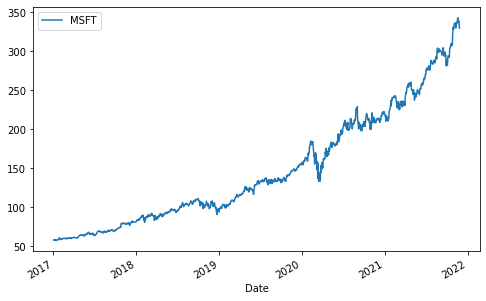

In [3]:
# importamos cierres diarios de la empresa
ticker = ['MSFT']
start_date = '2017-01-01'

closes_msft = get_adj_closes(ticker, start_date)
closes_msft.plot(figsize=(8,5));
plt.legend(ticker);

In [4]:
#ultimo cierre de la empresa
closes_msft.iloc[-1]

Symbols
MSFT    329.68
Name: 2021-11-26 00:00:00, dtype: float64

In [5]:
# calculamos los rendimientos diarios
ret_msft = calc_daily_ret(closes_msft)
# ret_msft.plot(figsize=(8,6));

### Call:

#### Escoger opcion call

In [6]:
#importamos información de opciones de la empresa para escoger nuestro put
msft_opt = options_chain('MSFT')
msft_opt

,contractSymbol,strike,bid,...,dte,CALL,mark
0,MSFT211203C00225000,225.0,103.3,...,0.016,True,105.050
1,MSFT211203C00230000,230.0,98.3,...,0.016,True,100.050
2,MSFT211203C00235000,235.0,93.3,...,0.016,True,95.050
3,MSFT211203C00240000,240.0,88.3,...,0.016,True,90.050
4,MSFT211203C00245000,245.0,83.3,...,0.016,True,85.075
...,...,...,...,...,...,...,...
1861,MSFT240119P00450000,450.0,133.0,...,2.145,False,135.250
1862,MSFT240119P00460000,460.0,141.5,...,2.145,False,143.750
1863,MSFT240119P00470000,470.0,150.0,...,2.145,False,152.250
1864,MSFT240119P00480000,480.0,158.5,...,2.145,False,160.750


In [9]:
# opción que quiero evaluar
K = 350.0 # strike price
indice_opt = msft_opt.loc[(msft_opt.CALL==True) & (msft_opt.strike==K) & (msft_opt.expirationDate=='2022-09-17 00:00:00')]
indice_opt

,contractSymbol,strike,bid,...,dte,CALL,mark
1208,MSFT220916C00350000,350.0,24.35,...,0.803,True,24.975


In [10]:
opt_valuar = indice_opt.loc[1208]
opt_valuar

contractSymbol    MSFT220916C00350000
strike                          350.0
bid                             24.35
ask                              25.6
volume                           45.0
                         ...         
inTheMoney                      False
expirationDate    2022-09-17 00:00:00
dte                             0.803
CALL                             True
mark                           24.975
Name: 1208, Length: 12, dtype: object

#### Simulación de precios

In [11]:
mu = ret_msft['MSFT'].mean()
sigma = ret_msft['MSFT'].std()
r = 0.0021/360
mu, sigma, r

(0.0014055802276222737, 0.01733517971343132, 5.833333333333333e-06)

In [12]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.expirationDate

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 1000

K = opt_valuar.strike
S0 = closes_msft['MSFT'].iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes

,0,1,2,...,997,998,999
2021-11-29,336.069,343.012,320.602,...,327.301,329.295,339.795
2021-11-30,335.362,339.291,318.116,...,335.850,329.275,338.203
2021-12-01,332.971,334.927,312.199,...,337.368,333.464,351.871
2021-12-02,328.685,338.534,314.476,...,339.412,334.731,350.038
2021-12-03,333.208,336.443,306.672,...,341.622,337.007,352.422
...,...,...,...,...,...,...,...
2022-09-12,448.070,352.185,172.332,...,421.319,246.374,536.987
2022-09-13,439.885,352.195,168.655,...,423.650,243.215,522.982
2022-09-14,443.253,359.721,171.286,...,423.346,238.693,523.408
2022-09-15,452.292,362.191,165.225,...,427.582,231.871,511.187


#### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

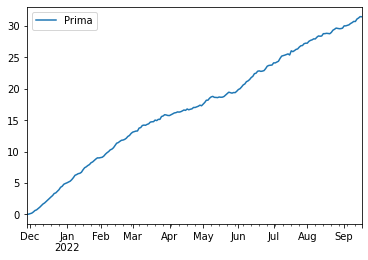

In [13]:
strike = K
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [14]:
call.iloc[-1]

Prima    31.472
Name: 2022-09-16 00:00:00, dtype: float64

#### Intervalo de Confianza

In [15]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(25.884660795465205, 37.05959701483932)


#### Histograma de rendimientos

In [16]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

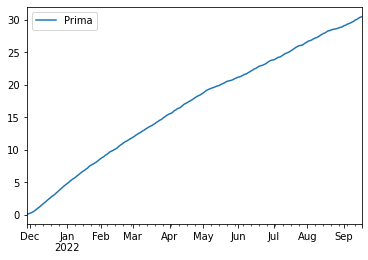

In [17]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.expirationDate

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.strike
S0 = closes_msft['MSFT'].iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [18]:
call_hist.iloc[-1]

Prima    30.467
Name: 2022-09-16 00:00:00, dtype: float64

In [19]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(28.76716539931565, 32.16675070958838)


#### Funcion indicadora Call down-and-out

In [20]:
pd.set_option('display.max_columns', 15)

# Precio barrera
B = 330

# Función de activación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes > B).cumprod(axis=0)  > 0
I

,0,1,2,3,4,5,6,...,993,994,995,996,997,998,999
2021-11-29,True,True,False,False,True,False,True,...,False,False,False,False,False,False,True
2021-11-30,True,True,False,False,True,False,True,...,False,False,False,False,False,False,True
2021-12-01,True,True,False,False,True,False,True,...,False,False,False,False,False,False,True
2021-12-02,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True
2021-12-03,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-12,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2022-09-13,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2022-09-14,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False
2022-09-15,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False


#### Call down-and-out

In [21]:
K = opt_valuar.strike
S0 = closes_msft['MSFT'].iloc[-1] # no tenemos el underlying price al usar yfinance entonces asumimos el ultimo de 
K, S0

(350.0, 329.67999267578125)

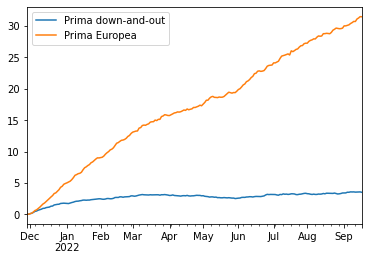

In [22]:
# Definir barrera
B = 330
# Crear función indicadora
I = (sim_closes > B).cumprod(axis=0) > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

Al analizar la acción de Microsoft, observamos que tiene una tendencia alcista. Esto significa que al tomar la posición de inversor, queremos un call. Y como estamos muy seguros de que esta acción seguirá subiendo, entonces usamos un call down and out. Esto significa que si por alguna razón baja a cierto nivel menor que el spot, la opción se desactivará. Esto reduce las pérdidas ya que si la acción baja antes de que la opción se venza, entonces la opción se desactiva. Y al tener la opción con barrera, se reduce la prima.

### Put:

#### Escoger opción put

In [23]:
# opción que quiero evaluar
K = 330.0 # strike price
indice_opt = msft_opt.loc[(msft_opt.CALL==False) & (msft_opt.strike==K) & (msft_opt.expirationDate=='2022-09-17 00:00:00')]
indice_opt

,contractSymbol,strike,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,dte,CALL,mark
1283,MSFT220916P00330000,330.0,32.1,35.1,39.0,1754.0,0.297,True,2022-09-17,0.803,False,33.6


In [24]:
opt_valuar = indice_opt.loc[1283]
opt_valuar

contractSymbol    MSFT220916P00330000
strike                          330.0
bid                              32.1
ask                              35.1
volume                           39.0
                         ...         
inTheMoney                       True
expirationDate    2022-09-17 00:00:00
dte                             0.803
CALL                            False
mark                             33.6
Name: 1283, Length: 12, dtype: object

#### Simulacion de precios

In [25]:
mu = ret_msft['MSFT'].mean()
sigma = ret_msft['MSFT'].std()
r = 0.0021/360
mu, sigma, r

from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.expirationDate

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 1000

K = opt_valuar.strike
S0 = closes_msft['MSFT'].iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

#### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

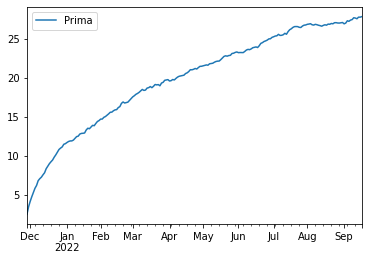

In [26]:
strike = K
put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike - sim_closes, 0).mean(axis=1)}, index=dates)
put.plot();

In [27]:
put.iloc[-1]

Prima    27.831
Name: 2022-09-16 00:00:00, dtype: float64

#### Intervalo de Confianza

In [28]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(22.477121736039017, 33.185370118251015)


#### Histograma de rendimientos

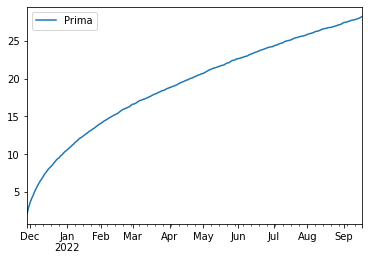

In [29]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.expirationDate

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.strike
S0 = closes_msft['MSFT'].iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike - sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();

In [30]:
put_hist.iloc[-1]

Prima    28.227
Name: 2022-09-16 00:00:00, dtype: float64

In [31]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(26.504592461114395, 29.950008846223202)


#### Función indicadora Put up-and-out

In [32]:
pd.set_option('display.max_columns', 15)

# Precio barrera
B = 380   

# Función de activación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod(axis=0)  > 0
I

,0,1,2,3,4,5,6,...,993,994,995,996,997,998,999
2021-11-29,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-11-30,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-12-01,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-12-02,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-12-03,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-12,False,False,False,True,True,False,True,...,True,False,False,True,True,True,True
2022-09-13,False,False,False,True,True,False,True,...,True,False,False,True,True,True,True
2022-09-14,False,False,False,True,True,False,True,...,True,False,False,True,True,True,True
2022-09-15,False,False,False,True,True,False,True,...,True,False,False,True,True,True,True


#### Put up-and-out

In [33]:
K = opt_valuar.strike
S0 = closes_msft['MSFT'].iloc[-1]
K,S0

(330.0, 329.67999267578125)

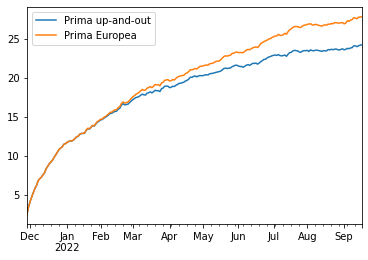

In [34]:
# Definir barrera
B = 380
# Crear función indicadora
I = (sim_closes < B).cumprod(axis=0) > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike - sim_closes, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(strike - sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot();
put.plot(ax=ax);

Como inversores, al tener un put, lo ideal es que la acción no suba. Pero en caso de que sí suba, podemos tener una opción barrera que desactive a la opción cuando esta suba a un valor mayor que el spot. De esta manera reducimos pérdidas y también se logra el objetivo que es abaratar a prima.

## Código de solución estudiante 2: Jose Antonio